In [3]:
# Copyright 2025 International Business Machines

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#  http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview
This notebook focuses on fine-tuning the [Prithvi EO v2.0 model](https://huggingface.co/collections/ibm-nasa-geospatial/prithvi-for-earth-observation-6740a7a81883466bf41d93d6) to classify crops in a HLS scene. The main take aways from this notebook will be as follows:
1. Learn how to use Terratorch to fine-tune Prithvi EO v2.0 300m for crop classification (13 classes).
2. Use Huggingface datasets with Prithvi EO.
3. Understand the effects of spefic parameters in training and hardware utilisation.
4. Use fine-tuned model for inference.

You may want to take this opportunity to double check you're using GPUs on Google Colab before proceeding any further. We have tested this notebook using T4 GPU on the free colab account.

## Setup
1. Install terratorch

To install the necessary packages, execute the cell below. This will take a few minutes. Once the installation process is done, a window will pop up to ask you to restart the session. This is normal and you should proceed to restart using the interface in the pop up window. Once the session has restarted, its important that you ignore the cell below, and go straight to section 0.1.3.


In [4]:
!pip install terratorch==1.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.6/851.6 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2. Import dependencies

In [5]:

import albumentations
import gdown
import lightning.pytorch as pl
import os
import terratorch
import torch
import matplotlib.pyplot as plt
import warnings
from huggingface_hub import hf_hub_download, snapshot_download
from pathlib import Path
from terratorch.datamodules import MultiTemporalCropClassificationDataModule

warnings.filterwarnings('ignore')

3. Download the dataset from Google Drive. To learn more about the datset used in this notebook, take a look a the Dataset card on [Hugging Face](https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification). This dataset contains Harmonized Landsat-Sentinel (HLS) and crop type classes across the Contiguous United States for the year 2022. The target labels are derived from USDA's Crop Data Layer (CDL). Each labels has 3 corresponding HLS images corresponding to different times of the year.

In [6]:
dataset_path = "../data/multi-temporal-crop-classification"

snapshot_download(
    repo_id="ibm-nasa-geospatial/multi-temporal-crop-classification",
    allow_patterns="*.tgz",
    repo_type="dataset",
    local_dir=dataset_path,
)
snapshot_download(
    repo_id="ibm-nasa-geospatial/multi-temporal-crop-classification",
    allow_patterns="*.txt",
    repo_type="dataset",
    local_dir=dataset_path,
)
!mkdir ../data/multi-temporal-crop-classification/training_chips; tar -xzf ../data/multi-temporal-crop-classification/training_chips.tgz -C ../data/multi-temporal-crop-classification/
!mkdir ../data/multi-temporal-crop-classification/validation_chips; tar -xzf ../data/multi-temporal-crop-classification/validation_chips.tgz -C ../data/multi-temporal-crop-classification/


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

validation_chips.tgz:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

training_chips.tgz:   0%|          | 0.00/10.6G [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

validation_data.txt:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

training_data.txt:   0%|          | 0.00/40.1k [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar

4. Truncate the dataset for demonstration purposes. Reducing the training dataset to a third of the original size means that model training takes only a few minutes with the resources available during the workshop.

In [7]:
training_data_truncation = 800
validation_data_trunction = 4
with open(f"{dataset_path}/training_data.txt", "r") as f:
      training_data_list = f.readlines()
truncated = training_data_list[0:training_data_truncation]
with open(f"{dataset_path}/training_data.txt", "w") as f:
    for i in truncated:
        f.write(i)

with open(f"{dataset_path}/validation_data.txt", "r") as f:
      training_data_list = f.readlines()
truncated = training_data_list[0:validation_data_trunction]
with open(f"{dataset_path}/validation_data.txt", "w") as f:
    for i in truncated:
        f.write(i)

## Multi-temporal Crop Dataset

Lets start with analysing the dataset.

Please note: we have also set the batch_size parameter to 4 and max_epochs to 1 to avoid running out of memory or runtime for users of the free tier colab compute resources. This is enough to demonstrate the entire workflow to the user, but may not result in the best performance. It'll be best to find additional compute resources and increase batch_size and max_epochs in the downloaded config file for improved performance.


In [8]:
# Each merged sample includes the stacked bands of three time steps
!ls "{dataset_path}/training_chips" | head

chip_003_062.mask.tif
chip_003_062_merged.tif
chip_003_063.mask.tif
chip_003_063_merged.tif
chip_010_063.mask.tif
chip_010_063_merged.tif
chip_019_091.mask.tif
chip_019_091_merged.tif
chip_022_126.mask.tif
chip_022_126_merged.tif


In [9]:
# Modify parameters to select the batch size, number of workers, model backbone and epochs ahead of initalizing the MultiTemporalCropClassificationDataModule class for multi-temporal crop classification.
batch_size = 4
num_workers = 2
prithvi_backbone = "prithvi_eo_v2_300_tl" # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl

# Total number of epochs the training will run for.
max_epochs =  1 # Use 1 epoch for demos


#### Initialise the Datamodules class

A Datamodule is a shareable, reusable class that encapsulates all the steps needed to process the data. Here we are using an adjusted dataset class for this dataset (general dataset class could be used as well). To learn more about MultiTemporalCropClassificationDataModule, take a look at the [TerraTorch docs](https://ibm.github.io/terratorch/stable/datamodules/?h=multitemporalcropclassificationdatamodule#terratorch.datamodules.multi_temporal_crop_classification.MultiTemporalCropClassificationDataModule).

In [10]:
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=batch_size,
    num_workers=num_workers,
    data_root=f"{dataset_path}",
    train_transform=[
        terratorch.datasets.transforms.FlattenTemporalIntoChannels(),  # Required for temporal data
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
        terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
    expand_temporal_dimension=True,
    use_metadata=False, # The crop dataset has metadata for location and time
    reduce_zero_label=True,
)

In [11]:
# Setup train and val datasets
datamodule.setup("fit")

In [12]:
datamodule.batch_size

4

In [13]:
# Mean and standard deviation calculated from the training dataset for all 6 bands, and 3 timesteps, for zero mean normalization.
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [14]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

800

In [15]:
# checking datasets available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [16]:
# checking datasets classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

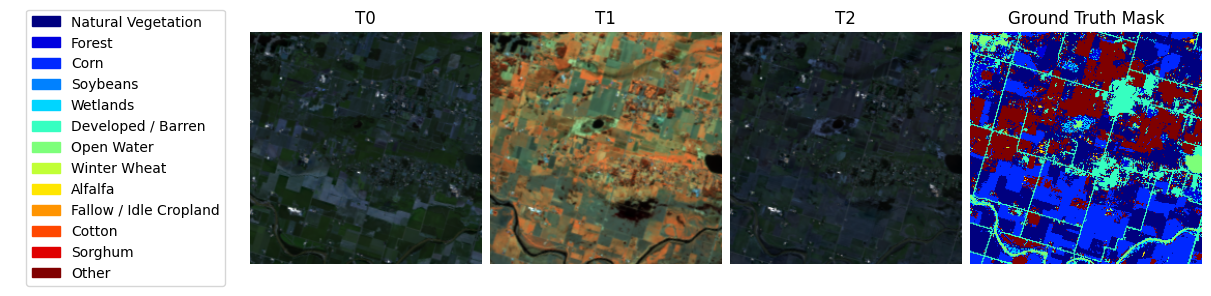

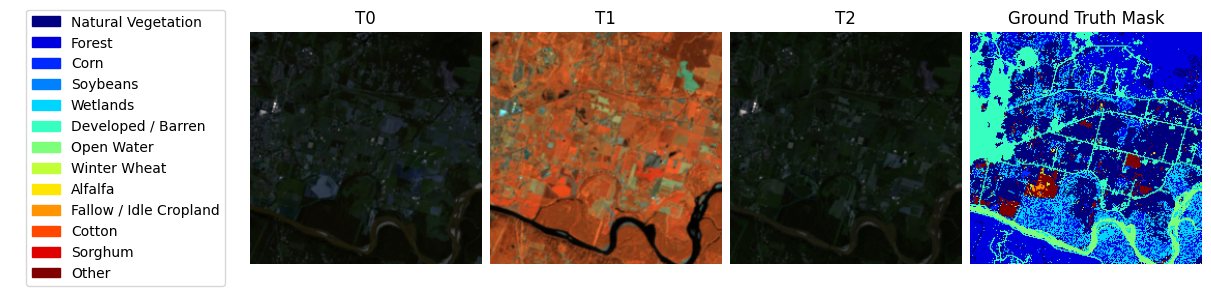

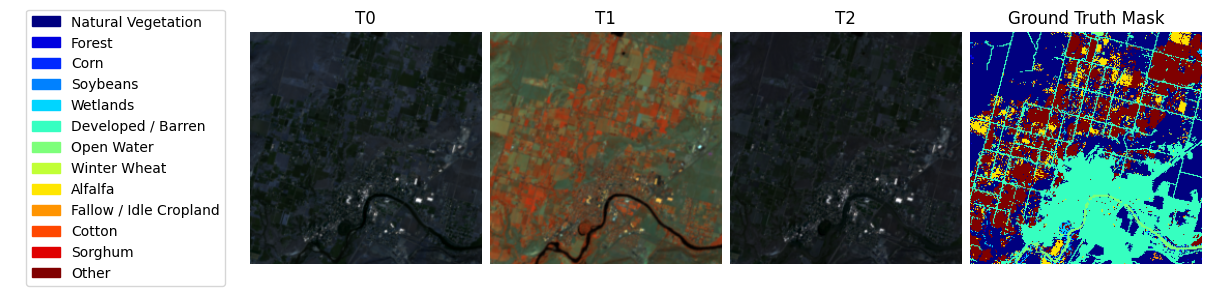

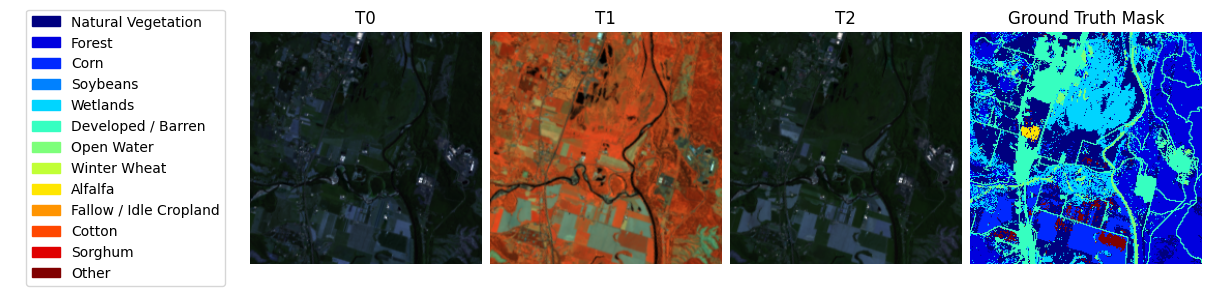

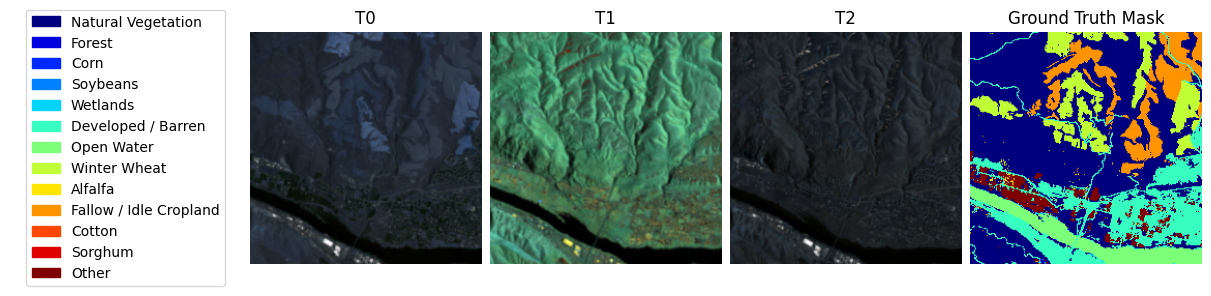

In [17]:
# plotting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [18]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

4

In [19]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

4

# Fine-tune Prithvi

Here we setup the fine-tuning including which type of task, which head to use and the model parameters. In this case we are doing segemtation task (you can take a look at this and other downstream tasks here [TerraTorch docs](https://ibm.github.io/terratorch/stable/tasks/)) and using a unet decoder. We also set the numbers of images per label with the "backbone_num_frames" parameter to allow us to perform multi-temporal classification.

In [20]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="../output/multicrop/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Lightning multi-gpu often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True, # Uses TensorBoard by default
    max_epochs=max_epochs,
    log_every_n_steps=5,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="../output/multicrop",
)

# Model
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": prithvi_backbone,
        "backbone_pretrained": True,
        "backbone_num_frames": 3,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11]  # 100m model
                "indices": [5, 11, 17, 23]  # 300m model
                # "indices": [7, 15, 23, 31]  # 300m model
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            },
            {"name": "LearnedInterpolateToPyramidal"},
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],

        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },

    loss="ce",
    lr=1e-4,
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

Prithvi_EO_V2_300M_TL.pt:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  383 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 79.9 M                                                                                           
Non-trainable params: 303 M                                                                                        
Total params: 383 M                                                                                                
Total estimated model params size (MB): 1.5 K                                                                      
Modules in train mode: 617                                                                                         
Modules in eval mode: 0

Output()

# Test the fine-tuned model

Let's gather and specify the relevant files for carrying out testing. Look for your .ckpt file produced during the fine-tuning process here it is in '../output/multicrop/checkpoints/best-epoch=00.ckpt'. We have also provided a model that has been trained on the full dataset so that we can compare it to our model.

In [ ]:
best_ckpt_path = "../output/multicrop/checkpoints/best-epoch=00.ckpt"

# Download best model checkpoint fine-tuned on full dataset
best_ckpt_100_epoch_path = "multicrop_best-epoch=76.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1cO5a9PmV70j6mvlTc8zH8MnKsRCGbefm")

In [ ]:
# calculate test metrics
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_100_epoch_path)

In [ ]:
# get predictions
preds = trainer.predict(model, datamodule=datamodule, ckpt_path=best_ckpt_100_epoch_path)

In [ ]:
# get data
data_loader = trainer.predict_dataloaders
batch = next(iter(data_loader))

# plot
for i in range(batch_size):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[0][0][0][i].cpu().numpy()

    datamodule.predict_dataset.plot(sample)

# Fine-tuning via CLI

We also run the fine-tuning via a [CLI](https://ibm.github.io/terratorch/stable/quick_start/#training-with-lightning-tasks). All parameteres we have specified in the notebook can be put in a [yaml]( ../configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml), and can be run using the command below. Take a look at the [TerraTorch docs](https://ibm.github.io/terratorch/stable/tutorials/the_yaml_config/) for how to setup the config.

You might want to restart the session to free up GPU memory.

In [ ]:
# First let's get the config file from github.com.
!git init
!git remote add origin https://github.com/IBM/ML4EO-workshop-2025.git
!git fetch --all
!git checkout origin/main -- "Prithvi-EO/configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml"

In [ ]:
# Run fine-tuning
!terratorch fit -c "Prithvi-EO/configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml"